<h6 align='center'>Kaggle competition: [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)</h6>

## Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (CNN)
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning
- remote gpu processing

## Libraries

In [66]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob # finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm #Used to show beautifull progress bars for computation and operations.
from PIL import Image #Python Imaging Library adds image processing capabilities
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim #Optimizers

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [67]:
use_gpu

True

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

In [6]:
DATA_DIR =  '/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/' 
# Local: #'/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/'


In [7]:
os.listdir(DATA_DIR)

['test_set', 'training_set']

In [9]:
trn_dir = f'{DATA_DIR}training_set' #creating path to the training set
val_dir = f'{DATA_DIR}test_set'

In [10]:
os.listdir(trn_dir)

['cats', 'dogs']

In [14]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg') #looking for files with a .jpg extension within subdirectories of the trn_dir directory.
trn_fnames[:3]

['/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1419.jpg',
 '/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.3899.jpg',
 '/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.38.jpg']

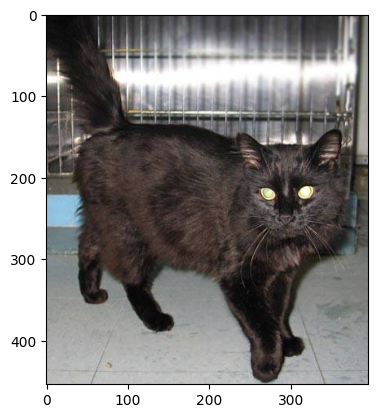

In [16]:
img = plt.imread(trn_fnames[10])
plt.imshow(img);

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [18]:
train_ds = datasets.ImageFolder(trn_dir)

In [19]:
train_ds.classes

['cats', 'dogs']

In [20]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [21]:
train_ds.root

'/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set'

In [22]:
train_ds.imgs

[('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.10.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.100.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1000.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1001.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1002.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1003.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1004.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1005.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1006.jpg',
  0),
 ('/mnt/home/mnikzad/ML_Practice/dog_vs_cat/dataset/training_set/cats/cat.1007.jpg',
  0),
 ('/m

In [82]:
# list(zip(*train_ds.imgs))

In [23]:
type(train_ds.transform)

NoneType

### Transformations

Dataloader object uses these tranformations when loading data.

In [24]:
sz = 224

In [25]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [26]:
len(train_ds), len(valid_ds)

(8000, 2000)

#### Dataloaders

In [32]:
batch_size = 64

In [33]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=2)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=2)

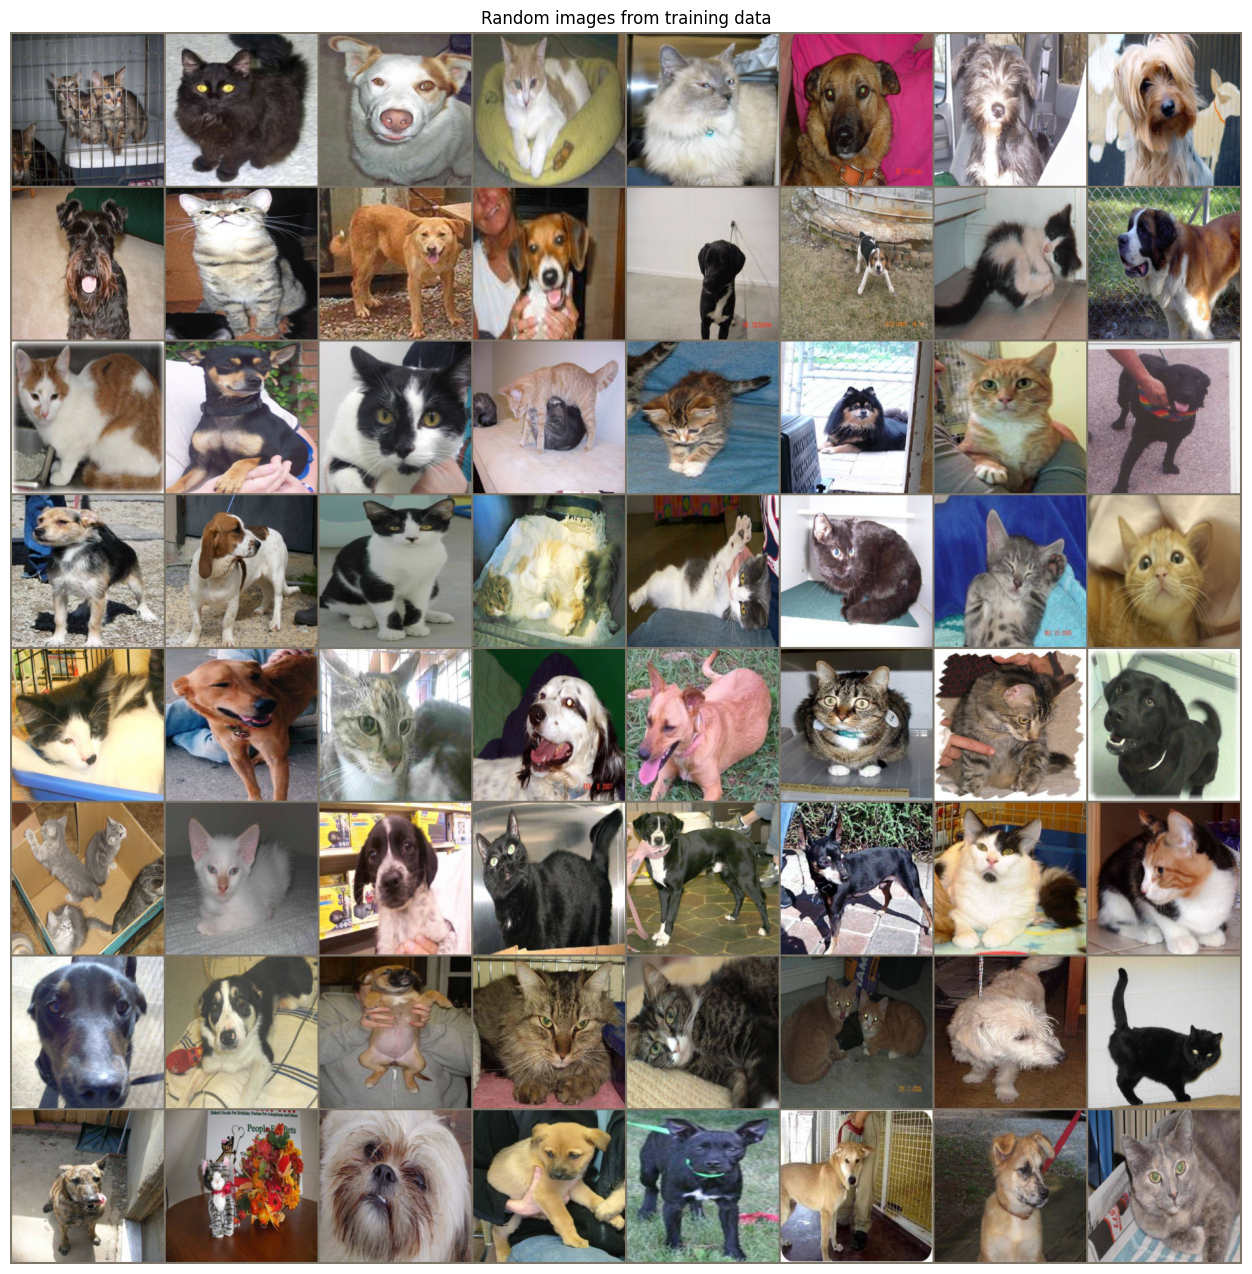

In [35]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 16))
imshow(out, title='Random images from training data')

## Model: CNN

<img src='imgs/DogAndCats-CNN.jpg' width='100%'/>

In [36]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

Now, it's time to create the model and to put it on the GPU.

In [38]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [39]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)

## Loss function and optimizer

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [46]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/10], Step [ 50/125], Loss: 0.3469
Epoch [ 1/10], Step [100/125], Loss: 0.3591
Epoch [ 2/10], Step [ 50/125], Loss: 0.3054
Epoch [ 2/10], Step [100/125], Loss: 0.3304
Epoch [ 3/10], Step [ 50/125], Loss: 0.2673
Epoch [ 3/10], Step [100/125], Loss: 0.2046
Epoch [ 4/10], Step [ 50/125], Loss: 0.2986
Epoch [ 4/10], Step [100/125], Loss: 0.2710
Epoch [ 5/10], Step [ 50/125], Loss: 0.2271
Epoch [ 5/10], Step [100/125], Loss: 0.2568
Epoch [ 6/10], Step [ 50/125], Loss: 0.1294
Epoch [ 6/10], Step [100/125], Loss: 0.0924
Epoch [ 7/10], Step [ 50/125], Loss: 0.1588
Epoch [ 7/10], Step [100/125], Loss: 0.0745
Epoch [ 8/10], Step [ 50/125], Loss: 0.1165
Epoch [ 8/10], Step [100/125], Loss: 0.0891
Epoch [ 9/10], Step [ 50/125], Loss: 0.0510
Epoch [ 9/10], Step [100/125], Loss: 0.0437
Epoch [10/10], Step [ 50/125], Loss: 0.0297
Epoch [10/10], Step [100/125], Loss: 0.0769


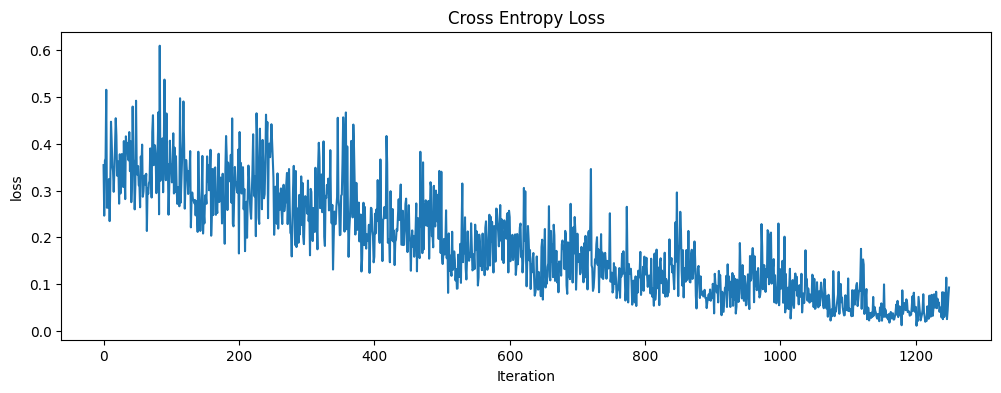

In [47]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

### Analyze results

#### Accuracy on validation data

In [48]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [49]:
evaluate_model(model, valid_dl, device)

accuracy: 69.80


In [50]:
evaluate_model(model, train_dl, device)

accuracy: 99.76


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


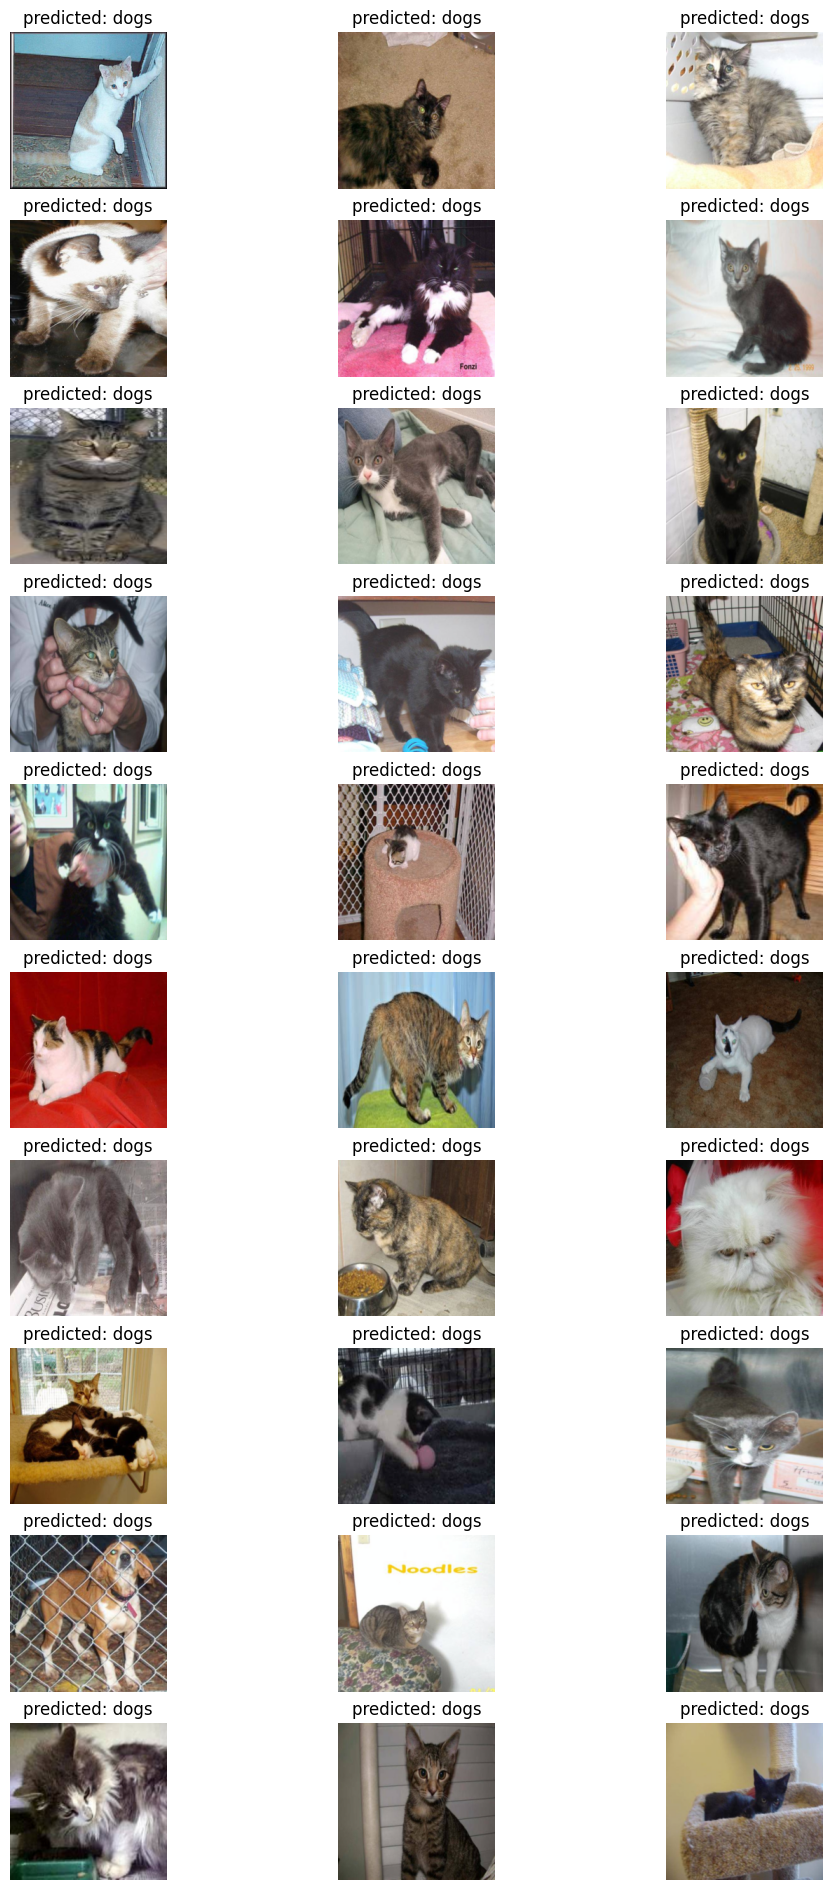

61 images out of 2000 were misclassified.


In [53]:
plot_errors(model, valid_dl, device)

#### Confusion matrix

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:06<00:00,  4.80it/s]


[[0.68 0.32]
 [0.28 0.72]]


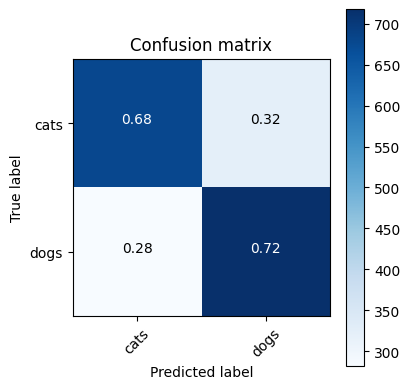

In [54]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Overfit

<h6>What we can do about it?</h6>

- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

## Data Augmentation

<h6>Possible Transformations:</h6>
- Scaling
- Rotation
- Translation
- Flip horizontaly
- Random Crop
- Color jitter
- many more!

In [56]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}training_set', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}test_set', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 8000
Valid size: 2000 (0.20)


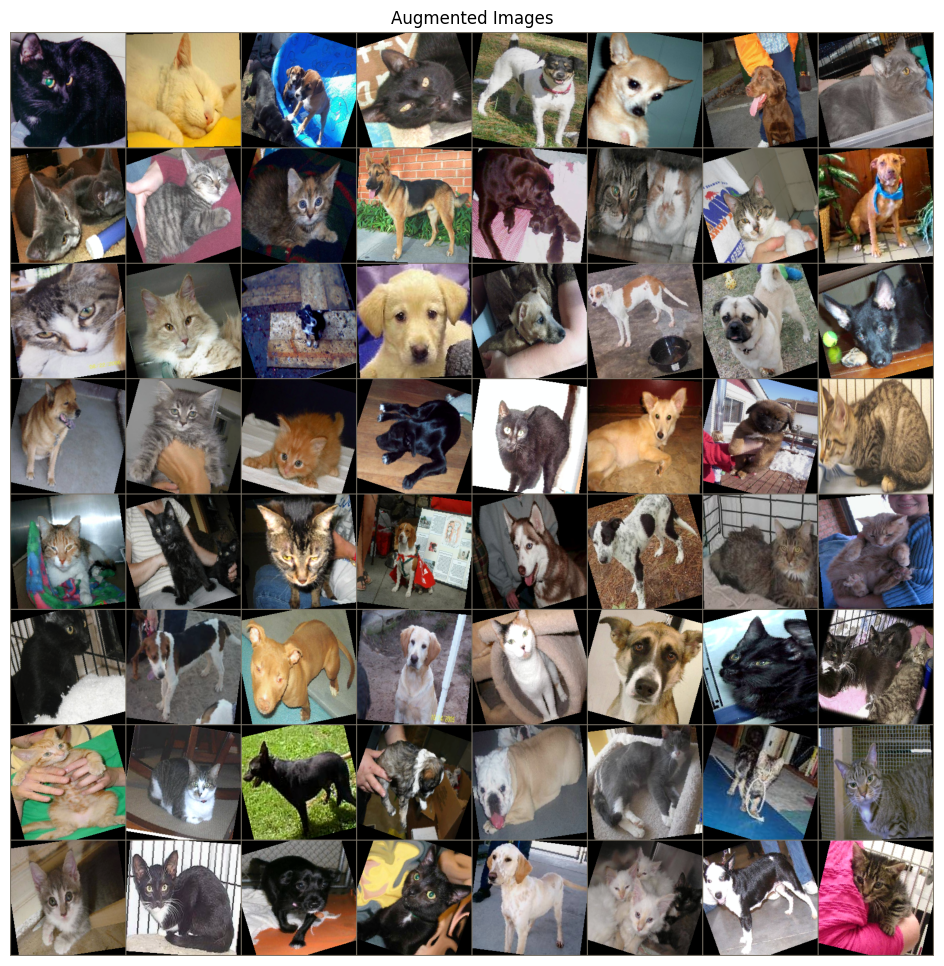

In [57]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

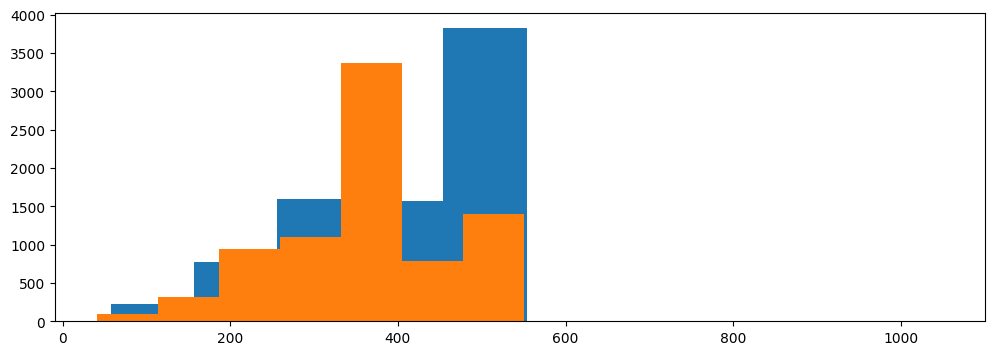

In [58]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [59]:
# create model
model = SimpleCNN()
model = model.to(device)
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=10)

Epoch 1/10
----------
  train Loss: 2.86075 Acc: 0.53388
  valid Loss: 0.79086 Acc: 0.58000

Epoch 2/10
----------
  train Loss: 0.74081 Acc: 0.59950
  valid Loss: 0.67402 Acc: 0.62450

Epoch 3/10
----------
  train Loss: 0.65936 Acc: 0.62588
  valid Loss: 0.66246 Acc: 0.60400

Epoch 4/10
----------
  train Loss: 0.61599 Acc: 0.66313
  valid Loss: 0.60381 Acc: 0.67050

Epoch 5/10
----------
  train Loss: 0.60509 Acc: 0.67063
  valid Loss: 0.57524 Acc: 0.70650

Epoch 6/10
----------
  train Loss: 0.58270 Acc: 0.69038
  valid Loss: 0.55910 Acc: 0.71650

Epoch 7/10
----------
  train Loss: 0.57018 Acc: 0.70113
  valid Loss: 0.55309 Acc: 0.71100

Epoch 8/10
----------
  train Loss: 0.55808 Acc: 0.71025
  valid Loss: 0.54580 Acc: 0.71450

Epoch 9/10
----------
  train Loss: 0.55090 Acc: 0.71150
  valid Loss: 0.54002 Acc: 0.72100

Epoch 10/10
----------
  train Loss: 0.54532 Acc: 0.72088
  valid Loss: 0.55923 Acc: 0.71100

Training complete in 15m 8s
Best val Acc: 0.7210


## Transfer Learning

- Use a CNN already trained on different data (e.g., [ImageNet](http://www.image-net.org/))
- Just Train the classifier weights (Last Layer)

<img src='imgs/transfer-learning.jpg' width='80%'/>

In [62]:
# load pre-trained ResNet50
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
#model = load_pretrained_resnet50(model_path=None, num_classes=2)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /mnt/home/mnikzad/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 12.3MB/s]


In [63]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 1.11731 Acc: 0.81625
  valid Loss: 0.04991 Acc: 0.98650

Epoch 2/2
----------
  train Loss: 0.03410 Acc: 0.98725
  valid Loss: 0.03407 Acc: 0.98950

Training complete in 4m 12s
Best val Acc: 0.9895


In [64]:
evaluate_model(model, valid_dl, device)

accuracy: 98.95


  0%|          | 0/32 [00:00<?, ?it/s]

 16%|█▌        | 5/32 [00:01<00:10,  2.55it/s]


IndexError: list index out of range

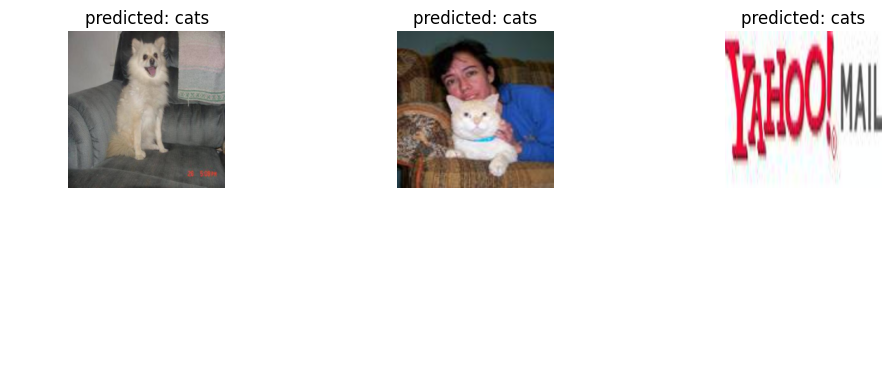

In [65]:
plot_errors(model, valid_dl, device)

## PROGRAMMING ASSIGNMENT 1

<div class="alert alert-success">
    <strong>[Plant Seeldlings Competition](https://www.kaggle.com/c/plant-seedlings-classification)</strong>
    <img src='imgs/PlantSeedling.png'/>
    <ul>
        <li><strong>Objective:</strong> getting a rank among top 50% in LB.</li>
        <li><strong>Ideas:</strong> different augmentations, different architectures, etc.</li>
        <li><strong>Important:</strong> share your ideas and progress on Piazza.</li>
    </ul>
</div>